#### import data

In [1]:
import pandas as pd  
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
data = pd.read_json('twitter_labeled_v2.json', lines =True)

In [10]:
len(data)

66035

In [11]:
data.isnull().sum()

favorite       0
language       0
magnitude    331
polarity       0
reply          0
retweet        0
score        331
text           0
time           0
dtype: int64

#### tranform label to binary vector [1,0,0] [0,1,0] [0,0,1] neg neural pos

In [12]:
data = data.drop(data.score[data.score.isnull()].index)# delete rows that api don't give the result
#(in this data 331 twitter don't have result)

In [13]:
len(data)

65704

#### score < -0.5 strong negative; score < 0 and score >= -0.5 negative; score == 0 neutral; score > 0 and score <= 0.5 positive; score > 0.5 strong positive

In [14]:
def get_label_value(score):
    if score < -0.5:
        return 0
    if score < 0 and score >= -0.5:
        return 1
    if score == 0:
        return 2
    if score > 0 and score <= 0.5:
        return 3
    if score > 0.5:
        return 4
data['label_value'] = data['score'].apply(get_label_value)

In [15]:
with open('final_twitter.json', 'w') as f:
    f.write(data.to_json(orient='records', lines=True))

In [16]:
from sklearn.preprocessing import label_binarize

y = label_binarize(data['label_value'], classes=[0, 1, 2,3,4])

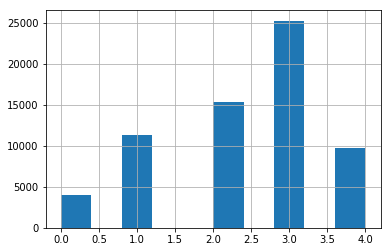

In [10]:
data.label_value.hist()# the data is not balance and most of twitters are positive or neutral

#### without emnbedding use tfidf vector as input nodes build a fully connected network

In [11]:
y[:5]

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0]])

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D,Conv1D, MaxPooling1D, Embedding

c:\users\temp\anaconda3\envs\tensorgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tf_vec = tfidf.fit_transform(data.text)

In [43]:
tf_vec.shape[1]

27639

In [185]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_vec, y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [45]:
X_train.shape,y_train.shape

((52563, 27639), (52563, 5))

In [186]:
#build first nerual network
model1 = Sequential()

model1.add(Dense(128, activation = 'relu', input_shape = (tf_vec.shape[1],)))

model1.add(Dropout(0.2))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(5, activation='sigmoid'))

In [47]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               3537920   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total params: 3,546,501
Trainable params: 3,546,501
Non-trainable params: 0
_________________________________________________________________


In [188]:
model1.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])

In [21]:
result = model1.fit(partial_x_train, partial_y_train, epochs=20,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 50563 samples, validate on 2000 samples
Epoch 1/20
50563/50563 [==============================] - 9s 184us/step - loss: 0.4544 - acc: 0.8112 - val_loss: 0.3826 - val_acc: 0.8278
Epoch 2/20
50563/50563 [==============================] - 8s 152us/step - loss: 0.3391 - acc: 0.8453 - val_loss: 0.3384 - val_acc: 0.8443
Epoch 3/20
50563/50563 [==============================] - 8s 152us/step - loss: 0.2947 - acc: 0.8688 - val_loss: 0.3246 - val_acc: 0.8523
Epoch 4/20
50563/50563 [==============================] - 8s 152us/step - loss: 0.2664 - acc: 0.8832 - val_loss: 0.3200 - val_acc: 0.8545
Epoch 5/20
50563/50563 [==============================] - 8s 154us/step - loss: 0.2439 - acc: 0.8949 - val_loss: 0.3184 - val_acc: 0.8577
Epoch 6/20
50563/50563 [==============================] - 8s 149us/step - loss: 0.2235 - acc: 0.9053 - val_loss: 0.3205 - val_acc: 0.8585
Epoch 7/20
50563/50563 [==============================] - 8s 152us/step - loss: 0.2067 - acc: 0.9147 - val_loss: 0.3273 - v

In [22]:
model1.evaluate(X_test, y_test, verbose=0)[1]

0.8514724959975898

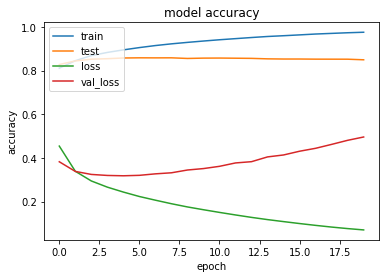

In [31]:
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test','loss','val_loss'], loc='upper left')
plt.show()

#### val loss increase in later epoch, better use early stop

In [ ]:
import numpy as np

In [33]:
np.argmax(y_test,axis=1)

array([4, 3, 3, ..., 3, 0, 3], dtype=int64)

In [35]:
predict1 = model1.predict(X_test, verbose=0)

In [36]:
np.argmax(predict1,axis=1)

array([3, 1, 3, ..., 3, 1, 4], dtype=int64)

In [3]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [109]:
classes = ['strong negative', 'negative', 'neutral','positive','strong positive']

In [46]:
pd.value_counts(np.argmax(y_test,axis=1))

3    5067
2    3035
1    2345
4    1900
0     794
dtype: int64

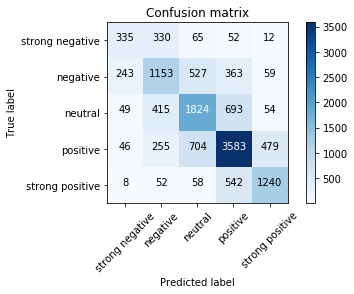

In [47]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(predict1,axis=1)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = classes) 

#### new part use early stopping

In [5]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0),]

In [189]:
result = model1.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 10s 183us/step - loss: 0.4361 - acc: 0.8154 - val_loss: 0.3612 - val_acc: 0.8318
Epoch 2/20
53219/53219 [==============================] - 9s 164us/step - loss: 0.3296 - acc: 0.8466 - val_loss: 0.3382 - val_acc: 0.8424
Epoch 3/20
53219/53219 [==============================] - 9s 161us/step - loss: 0.2918 - acc: 0.8701 - val_loss: 0.3334 - val_acc: 0.8508
Epoch 4/20
53219/53219 [==============================] - 9s 160us/step - loss: 0.2616 - acc: 0.8875 - val_loss: 0.3385 - val_acc: 0.8495
Epoch 5/20
53219/53219 [==============================] - 8s 160us/step - loss: 0.2352 - acc: 0.9012 - val_loss: 0.3489 - val_acc: 0.8500


In [190]:
predict2 = model1.predict(X_test, verbose=0)

In [191]:
model1.evaluate(X_test, y_test, verbose=0)[1]

0.8453812215212473

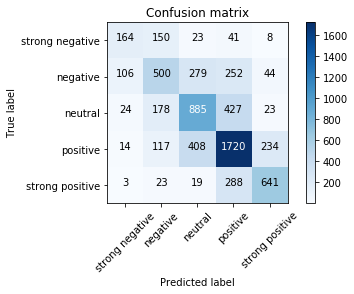

In [192]:
confusion_mtx = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(predict2,axis=1)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = classes) 

#### add regularizer

In [64]:
model1 = Sequential()

model1.add(Dense(128, activation = 'relu', input_shape = (tf_vec.shape[1],),kernel_regularizer=regularizers.l2(0.01),
                ))

model1.add(Dropout(0.2))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(5, activation='sigmoid'))

In [68]:
model1.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result = model1.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 50563 samples, validate on 2000 samples
Epoch 1/20
50563/50563 [==============================] - 8s 159us/step - loss: 0.4056 - acc: 0.8429 - val_loss: 0.3970 - val_acc: 0.8405
Epoch 2/20
50563/50563 [==============================] - 8s 149us/step - loss: 0.3874 - acc: 0.8471 - val_loss: 0.3985 - val_acc: 0.8412
Epoch 3/20
50563/50563 [==============================] - 8s 149us/step - loss: 0.3853 - acc: 0.8480 - val_loss: 0.4004 - val_acc: 0.8414


In [66]:
model1.evaluate(X_test, y_test, verbose=0)[1]

0.8459934635110101

#### add maxnorm

In [193]:
from keras.constraints import maxnorm
model1 = Sequential()

model1.add(Dense(128, activation = 'relu', input_shape = (tf_vec.shape[1],),kernel_constraint=maxnorm(3),
                ))

model1.add(Dropout(0.2))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(5, activation='sigmoid'))
model1.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result = model1.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 9s 177us/step - loss: 0.4485 - acc: 0.8105 - val_loss: 0.3661 - val_acc: 0.8290
Epoch 2/20
53219/53219 [==============================] - 9s 161us/step - loss: 0.3352 - acc: 0.8443 - val_loss: 0.3415 - val_acc: 0.8398
Epoch 3/20
53219/53219 [==============================] - 9s 162us/step - loss: 0.2982 - acc: 0.8668 - val_loss: 0.3363 - val_acc: 0.8513
Epoch 4/20
53219/53219 [==============================] - 9s 161us/step - loss: 0.2680 - acc: 0.8841 - val_loss: 0.3393 - val_acc: 0.8493
Epoch 5/20
53219/53219 [==============================] - 9s 162us/step - loss: 0.2413 - acc: 0.8987 - val_loss: 0.3460 - val_acc: 0.8508


In [194]:
model1.evaluate(X_test, y_test, verbose=0)[1]

0.8474509254599104

#### use filter stop words as input

In [90]:
tfidf = TfidfVectorizer(lowercase=True, norm=None, stop_words='english', use_idf=False)
tf_vec = tfidf.fit_transform(data.text)
X_train, X_test, y_train, y_test = train_test_split(tf_vec, y, test_size=0.2, random_state=2)

In [93]:
tf_vec.shape

(65704, 27343)

In [99]:
from keras.constraints import maxnorm
model1 = Sequential()

model1.add(Dense(128, activation = 'relu', input_shape = (tf_vec.shape[1],),kernel_constraint=maxnorm(3),
                ))

model1.add(Dropout(0.2))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(5, activation='sigmoid'))
model1.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result = model1.fit(X_train, y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_split = 0.1, callbacks=callbacks)

Train on 47306 samples, validate on 5257 samples
Epoch 1/20
47306/47306 [==============================] - 8s 174us/step - loss: 0.4475 - acc: 0.8128 - val_loss: 0.3676 - val_acc: 0.8289
Epoch 2/20
47306/47306 [==============================] - 8s 163us/step - loss: 0.3359 - acc: 0.8437 - val_loss: 0.3392 - val_acc: 0.8404
Epoch 3/20
47306/47306 [==============================] - 8s 163us/step - loss: 0.2957 - acc: 0.8685 - val_loss: 0.3338 - val_acc: 0.8497
Epoch 4/20
47306/47306 [==============================] - 8s 161us/step - loss: 0.2655 - acc: 0.8855 - val_loss: 0.3351 - val_acc: 0.8493
Epoch 5/20
47306/47306 [==============================] - 8s 163us/step - loss: 0.2388 - acc: 0.8990 - val_loss: 0.3430 - val_acc: 0.8479


In [100]:
model1.evaluate(X_test, y_test, verbose=0)[1]

0.8454455568968057

#### amazing!  the orignial model i use 30000 twitter , labeld from paralleldots api(only give pos neg neu) the result is 80%

#### build  a CNN model with embedding, padding layers, using keras tokenizer get input nodes

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#### keras tokenlzer: fit_on_texts(data.text):get vocabulary list with each index
#####tokenizer.texts_to_sequences: rebuild each sentence with word index

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)
sequences = tokenizer.texts_to_sequences(data.text)

In [68]:
data.text[0]

'waves community launches "guess the seed" competition win 500 waves tokens!'

In [66]:
sequences[0]

[1402, 176, 1685, 658, 1, 5630, 1566, 119, 199, 1402, 54]

In [61]:
max([len(x) for x in sequences])


61

### the highest word number in a twitter list is 65. pad other sentence with 0 value to make every sentence have same length

In [23]:
x_model2 = pad_sequences(sequences, maxlen=65)

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_model2, y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [25]:
embedding_dim = 200#set word vector'length
word_count = len(tokenizer.word_index)

In [38]:
model2 = Sequential()
model2.add(Embedding(word_count + 1, embedding_dim, input_length=65))
model2.add(Dropout(0.2))
model2.add(Conv1D(250, 3, padding='valid', activation='relu'))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is 65
model2.add(MaxPooling1D(3))
model2.add(Flatten())
model2.add(Dense(200, activation='relu'))
model2.add(Dense(5, activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 65, 200)           5864200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 65, 200)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 63, 250)           150250    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 21, 250)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5250)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               1050200   
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1005      
Total para

In [27]:
model2.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result2 = model2.fit(partial_x_train, partial_y_train, epochs=20,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 6s 116us/step - loss: 0.4000 - acc: 0.8254 - val_loss: 0.3273 - val_acc: 0.8526
Epoch 2/20
53219/53219 [==============================] - 3s 52us/step - loss: 0.2999 - acc: 0.8640 - val_loss: 0.2950 - val_acc: 0.8645
Epoch 3/20
53219/53219 [==============================] - 3s 52us/step - loss: 0.2574 - acc: 0.8859 - val_loss: 0.2930 - val_acc: 0.8673
Epoch 4/20
53219/53219 [==============================] - 3s 52us/step - loss: 0.2275 - acc: 0.9013 - val_loss: 0.2949 - val_acc: 0.8686
Epoch 5/20
53219/53219 [==============================] - 3s 52us/step - loss: 0.1983 - acc: 0.9168 - val_loss: 0.3134 - val_acc: 0.8670
Epoch 6/20
53219/53219 [==============================] - 3s 52us/step - loss: 0.1700 - acc: 0.9307 - val_loss: 0.3206 - val_acc: 0.8636
Epoch 7/20
53219/53219 [==============================] - 3s 52us/step - loss: 0.1424 - acc: 0.9435 - val_loss: 0.3389 - val_acc

In [28]:
def showplot(result):
    plt.plot(result.history['acc'])
    plt.plot(result.history['val_acc'])
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test','loss','val_loss'], loc='upper left')
    plt.show()

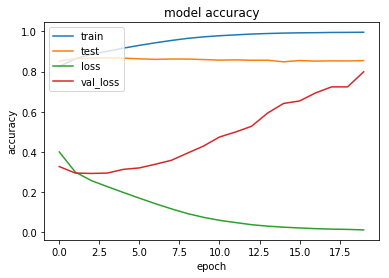

In [29]:
showplot(result2)

In [30]:
model2.evaluate(X_test, y_test, verbose=0)[1]

0.8471769949033223

#### fix overfitting

In [39]:
model2.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result2_early = model2.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 3s 57us/step - loss: 0.3931 - acc: 0.8271 - val_loss: 0.3246 - val_acc: 0.8528
Epoch 2/20
53219/53219 [==============================] - 3s 50us/step - loss: 0.2956 - acc: 0.8654 - val_loss: 0.3077 - val_acc: 0.8594
Epoch 3/20
53219/53219 [==============================] - 3s 50us/step - loss: 0.2561 - acc: 0.8858 - val_loss: 0.2928 - val_acc: 0.8666
Epoch 4/20
53219/53219 [==============================] - 3s 51us/step - loss: 0.2274 - acc: 0.9010 - val_loss: 0.2926 - val_acc: 0.8681
Epoch 5/20
53219/53219 [==============================] - 3s 50us/step - loss: 0.1998 - acc: 0.9151 - val_loss: 0.2982 - val_acc: 0.8681
Epoch 6/20
53219/53219 [==============================] - 3s 50us/step - loss: 0.1734 - acc: 0.9287 - val_loss: 0.3058 - val_acc: 0.8678


In [40]:
model2.evaluate(X_test, y_test, verbose=0)[1]

0.8614213986314063

#### add regularizer

In [57]:
from keras import regularizers

In [69]:
model2 = Sequential()
model2.add(Embedding(word_count + 1, embedding_dim, input_length=65))
model2.add(Dropout(0.2))
model2.add(Conv1D(250, 3, padding='valid', activation='relu',kernel_regularizer=regularizers.l2(0.01)))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is 65
model2.add(MaxPooling1D(3))
model2.add(Flatten())
model2.add(Dense(200, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 65, 200)           5864200   
_________________________________________________________________
dropout_13 (Dropout)         (None, 65, 200)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 63, 250)           150250    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 21, 250)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 5250)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 200)               1050200   
_________________________________________________________________
dropout_14 (Dropout)         (None, 200)               0         
__________

In [71]:
model2.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result2_early_regu = model2.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 3s 60us/step - loss: 0.7329 - acc: 0.8130 - val_loss: 0.4035 - val_acc: 0.8315
Epoch 2/20
53219/53219 [==============================] - 3s 51us/step - loss: 0.3707 - acc: 0.8407 - val_loss: 0.3490 - val_acc: 0.8509
Epoch 3/20
53219/53219 [==============================] - 3s 51us/step - loss: 0.3353 - acc: 0.8563 - val_loss: 0.3678 - val_acc: 0.8373
Epoch 4/20
53219/53219 [==============================] - 3s 51us/step - loss: 0.3155 - acc: 0.8663 - val_loss: 0.3248 - val_acc: 0.8589
Epoch 5/20
53219/53219 [==============================] - 3s 51us/step - loss: 0.2994 - acc: 0.8746 - val_loss: 0.3227 - val_acc: 0.8584
Epoch 6/20
53219/53219 [==============================] - 3s 51us/step - loss: 0.2875 - acc: 0.8813 - val_loss: 0.3484 - val_acc: 0.8568
Epoch 7/20
53219/53219 [==============================] - 3s 51us/step - loss: 0.2767 - acc: 0.8871 - val_loss: 0.3291 - val_acc:

In [72]:
model2.evaluate(X_test, y_test, verbose=0)[1]

0.8578298617363557

#### seems regulizer can reduce overfitting greatly but also reduce accuacy 

#### add maxnorm 

In [104]:
from keras.constraints import maxnorm
model2 = Sequential()
model2.add(Embedding(word_count + 1, embedding_dim, input_length=65))
model2.add(Dropout(0.2))
model2.add(Conv1D(250, 3, padding='valid', activation='relu', kernel_constraint=maxnorm(3)))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is 65
model2.add(MaxPooling1D(3))
model2.add(Flatten())
model2.add(Dense(200, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))


In [105]:
model2.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result2_early_batch = model2.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 3s 65us/step - loss: 0.4017 - acc: 0.8241 - val_loss: 0.3335 - val_acc: 0.8502
Epoch 2/20
53219/53219 [==============================] - 3s 53us/step - loss: 0.3032 - acc: 0.8620 - val_loss: 0.2949 - val_acc: 0.8651
Epoch 3/20
53219/53219 [==============================] - 3s 53us/step - loss: 0.2638 - acc: 0.8821 - val_loss: 0.2868 - val_acc: 0.8691
Epoch 4/20
53219/53219 [==============================] - 3s 53us/step - loss: 0.2361 - acc: 0.8970 - val_loss: 0.2891 - val_acc: 0.8700
Epoch 5/20
53219/53219 [==============================] - 3s 52us/step - loss: 0.2095 - acc: 0.9113 - val_loss: 0.2991 - val_acc: 0.8676


In [106]:
model2.evaluate(X_test, y_test, verbose=0)[1]

0.8651955626341437

In [107]:
predict2 = model2.predict(X_test, verbose=0)

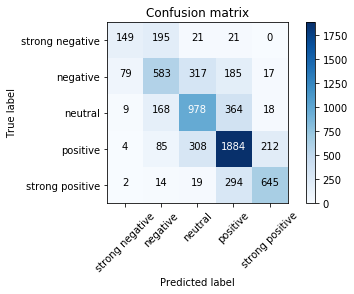

In [110]:
confusion_mtx = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(predict2,axis=1)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = classes) 

#### combined wordvec2 with cnn

#### because I build two wordvec2 model based on have stop words or not,so I should build a embedding layers by my self

##### single word wordvec2 model

In [111]:
from gensim.models import Word2Vec
import gensim
import re

In [112]:
wv2single = gensim.models.word2vec.Word2Vec.load("singleword2v.w2v")
wv2_single_voc = list(wv2single.wv.vocab.keys())
wv2_single_voc_dict = dict(zip(wv2_single_voc,list(range(len(wv2_single_voc)))))
wv2_single_sequences = []
for text in data.text:
    temp_vec = []
    for word in text.split():
        if word in wv2_single_voc:
            temp_vec.append(wv2_single_voc_dict[word])
    wv2_single_sequences.append(temp_vec)

In [26]:
wv2single.wv.most_similar('good')

[('great', 0.8452621102333069),
 ('nice', 0.7789426445960999),
 ('forward', 0.7583998441696167),
 ('bad', 0.6935279369354248),
 ('amazing', 0.6809878349304199),
 ('positive', 0.656152069568634),
 ('awesome', 0.6407425403594971),
 ('better', 0.639358401298523),
 ('pretty', 0.632267951965332),
 ('big', 0.6230407953262329)]

In [113]:
len(wv2_single_voc)

6646

In [114]:
len(wv2_single_sequences)

65704

In [115]:
max([len(a) for a in wv2_single_sequences])

41

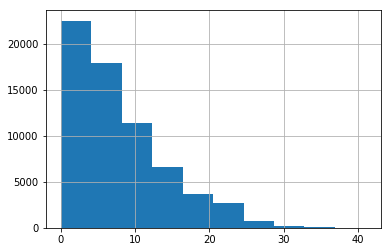

In [30]:
pd.Series([len(a) for a in wv2_single_sequences]).hist()

In [116]:
x_model3 = pad_sequences(wv2_single_sequences, maxlen=45)

In [117]:
embedding_matrix = np.zeros((len(wv2_single_voc_dict)+ 1, 100))
for word,index in wv2_single_voc_dict.items():
    embedding_matrix[index] = wv2single.wv[word]

In [118]:
embedding_matrix.shape

(6647, 100)

In [119]:
embedding_layer = Embedding(len(wv2_single_voc_dict)+ 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=45,
                            trainable=False)


In [120]:
X_train, X_test, y_train, y_test = train_test_split(x_model3, y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [121]:
model3 = Sequential()
model3.add(embedding_layer)
model3.add(Dropout(0.2))
model3.add(Conv1D(250, 3, padding='valid', activation='relu'))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
#model3.add(MaxPooling1D(3))
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dense(5, activation='softmax'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 45, 100)           664700    
_________________________________________________________________
dropout_32 (Dropout)         (None, 45, 100)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 43, 250)           75250     
_________________________________________________________________
flatten_15 (Flatten)         (None, 10750)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 100)               1075100   
_________________________________________________________________
dense_54 (Dense)             (None, 5)                 505       
Total params: 1,815,555
Trainable params: 1,150,855
Non-trainable params: 664,700
____________________________________________________________

In [122]:
model3.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result3 = model3.fit(partial_x_train, partial_y_train, epochs=20,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 2s 36us/step - loss: 0.4404 - acc: 0.8151 - val_loss: 0.3886 - val_acc: 0.8228
Epoch 2/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3819 - acc: 0.8291 - val_loss: 0.3754 - val_acc: 0.8313
Epoch 3/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3689 - acc: 0.8357 - val_loss: 0.3710 - val_acc: 0.8347
Epoch 4/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3574 - acc: 0.8412 - val_loss: 0.3679 - val_acc: 0.8357
Epoch 5/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3483 - acc: 0.8461 - val_loss: 0.3631 - val_acc: 0.8382
Epoch 6/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3391 - acc: 0.8498 - val_loss: 0.3663 - val_acc: 0.8364
Epoch 7/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3297 - acc: 0.8549 - val_loss: 0.3726 - val_acc:

In [123]:
model3.evaluate(X_test, y_test, verbose=0)[1]

0.8223710334150418

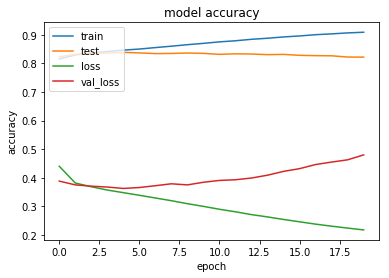

In [124]:
showplot(result3)

In [131]:
model3 = Sequential()
model3.add(embedding_layer)
model3.add(Dropout(0.2))
model3.add(Conv1D(250, 3, padding='valid', activation='relu', kernel_constraint=maxnorm(3)))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
#model3.add(MaxPooling1D(3))
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dense(5, activation='softmax'))
model3.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result3 = model3.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 2s 34us/step - loss: 0.4380 - acc: 0.8127 - val_loss: 0.3920 - val_acc: 0.8226
Epoch 2/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3831 - acc: 0.8288 - val_loss: 0.3745 - val_acc: 0.8333
Epoch 3/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3698 - acc: 0.8346 - val_loss: 0.3690 - val_acc: 0.8359
Epoch 4/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3595 - acc: 0.8395 - val_loss: 0.3669 - val_acc: 0.8371
Epoch 5/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3494 - acc: 0.8446 - val_loss: 0.3660 - val_acc: 0.8373
Epoch 6/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3405 - acc: 0.8488 - val_loss: 0.3659 - val_acc: 0.8376
Epoch 7/20
53219/53219 [==============================] - 1s 21us/step - loss: 0.3310 - acc: 0.8541 - val_loss: 0.3730 - val_acc:

In [132]:
model3.evaluate(X_test, y_test, verbose=0)[1]

0.8349414196592763

#### use a single word model that have stop words

In [133]:
wv2single = gensim.models.word2vec.Word2Vec.load("nofilter.w2v")
wv2_single_voc = list(wv2single.wv.vocab.keys())
wv2_single_voc_dict = dict(zip(wv2_single_voc,list(range(len(wv2_single_voc)))))
wv2_single_sequences = []
for text in data.text:
    temp_vec = []
    
    for word in text.split():
        if word in wv2_single_voc:
            temp_vec.append(wv2_single_voc_dict[word])
    wv2_single_sequences.append(temp_vec)


In [134]:
len(wv2_single_voc)

8992

In [135]:
max([len(a) for a in wv2_single_sequences])

60

In [136]:
x_model3 = pad_sequences(wv2_single_sequences, maxlen=60)

In [137]:
embedding_matrix = np.zeros((len(wv2_single_voc_dict)+ 1, 200))
for word,index in wv2_single_voc_dict.items():
    embedding_matrix[index] = wv2single .wv[word]

In [138]:
embedding_matrix.shape

(8993, 200)

In [139]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_model3, y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [140]:
embedding_layer = Embedding(len(wv2_single_voc_dict)+ 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=60,
                            trainable=False)


In [141]:
model3 = Sequential()
model3.add(embedding_layer)
model3.add(Dropout(0.2))
model3.add(Conv1D(250, 3, padding='valid', activation='relu'))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
model3.add(MaxPooling1D(3))
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dense(5, activation='softmax'))

In [142]:
model3.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result3 = model3.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 2s 46us/step - loss: 0.4354 - acc: 0.8171 - val_loss: 0.3841 - val_acc: 0.8298
Epoch 2/20
53219/53219 [==============================] - 2s 31us/step - loss: 0.3757 - acc: 0.8340 - val_loss: 0.3658 - val_acc: 0.8383
Epoch 3/20
53219/53219 [==============================] - 2s 31us/step - loss: 0.3579 - acc: 0.8409 - val_loss: 0.3615 - val_acc: 0.8421
Epoch 4/20
53219/53219 [==============================] - 2s 31us/step - loss: 0.3464 - acc: 0.8467 - val_loss: 0.3557 - val_acc: 0.8424
Epoch 5/20
53219/53219 [==============================] - 2s 31us/step - loss: 0.3342 - acc: 0.8519 - val_loss: 0.3564 - val_acc: 0.8406
Epoch 6/20
53219/53219 [==============================] - 2s 31us/step - loss: 0.3214 - acc: 0.8587 - val_loss: 0.3614 - val_acc: 0.8429


In [143]:
model3.evaluate(X_test, y_test, verbose=0)[1]

0.8393243107416916

In [144]:
model3 = Sequential()
model3.add(embedding_layer)
model3.add(Dropout(0.2))
model3.add(Conv1D(250, 3, padding='valid', activation='relu', kernel_constraint=maxnorm(3)))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
model3.add(MaxPooling1D(3))
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dense(5, activation='softmax'))
model3.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result3 = model3.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 2s 46us/step - loss: 0.4305 - acc: 0.8166 - val_loss: 0.3881 - val_acc: 0.8301
Epoch 2/20
53219/53219 [==============================] - 2s 31us/step - loss: 0.3753 - acc: 0.8339 - val_loss: 0.3737 - val_acc: 0.8348
Epoch 3/20
53219/53219 [==============================] - 2s 31us/step - loss: 0.3579 - acc: 0.8414 - val_loss: 0.3590 - val_acc: 0.8418
Epoch 4/20
53219/53219 [==============================] - 2s 31us/step - loss: 0.3451 - acc: 0.8471 - val_loss: 0.3674 - val_acc: 0.8372
Epoch 5/20
53219/53219 [==============================] - 2s 31us/step - loss: 0.3334 - acc: 0.8525 - val_loss: 0.3614 - val_acc: 0.8391


In [145]:
model3.evaluate(X_test, y_test, verbose=0)[1]

0.8386547022931853

#### use pretrained glove model

In [89]:
import gensim.downloader as api
glove_twitter = api.load("glove-twitter-200")

c:\users\temp\anaconda3\envs\tensorgpu\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [146]:
glove_twitter.wv.most_similar('good')

c:\users\temp\anaconda3\envs\tensorgpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('great', 0.8672515749931335),
 ('well', 0.8378019332885742),
 ('nice', 0.8338046073913574),
 ('better', 0.8206877112388611),
 ('night', 0.8163402080535889),
 ('morning', 0.8079935908317566),
 ('but', 0.8020180463790894),
 ('bad', 0.7983508110046387),
 ('too', 0.7936956286430359),
 ('it', 0.7926609516143799)]

In [9]:
len(glove_twitter.wv.vocab.keys())

C:\Users\TEMP\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


1193514

In [147]:
embeddings_index = {}
for w in glove_twitter.vocab.keys():
    embeddings_index[w] = glove_twitter[w]

In [149]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)
sequences = tokenizer.texts_to_sequences(data.text)

In [150]:
len(tokenizer.word_index)#tokenizer.word_index

29320

In [151]:
modelx6 = pad_sequences(sequences, maxlen=65)

In [152]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
for word, i in tokenizer.word_index.items():
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [153]:
embedding_matrix.shape

(29321, 200)

In [154]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(modelx6, y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [155]:
model6 = Sequential()
model6.add(Embedding(len(tokenizer.word_index)+1, 200, weights=[embedding_matrix], input_length=65, trainable=False))
model6.add(Dropout(0.2))
model6.add(Conv1D(250, 3, padding='valid', activation='relu'))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
model6.add(MaxPooling1D(3))
model6.add(Flatten())
model6.add(Dense(100, activation='relu'))
model6.add(Dense(5, activation='softmax'))


In [156]:
model6.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result6 = model6.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 2s 47us/step - loss: 0.4028 - acc: 0.8246 - val_loss: 0.3488 - val_acc: 0.8434
Epoch 2/20
53219/53219 [==============================] - 2s 33us/step - loss: 0.3382 - acc: 0.8456 - val_loss: 0.3261 - val_acc: 0.8504
Epoch 3/20
53219/53219 [==============================] - 2s 33us/step - loss: 0.3166 - acc: 0.8565 - val_loss: 0.3148 - val_acc: 0.8558
Epoch 4/20
53219/53219 [==============================] - 2s 33us/step - loss: 0.3008 - acc: 0.8651 - val_loss: 0.3094 - val_acc: 0.8584
Epoch 5/20
53219/53219 [==============================] - 2s 33us/step - loss: 0.2850 - acc: 0.8731 - val_loss: 0.3162 - val_acc: 0.8568
Epoch 6/20
53219/53219 [==============================] - 2s 33us/step - loss: 0.2713 - acc: 0.8804 - val_loss: 0.3143 - val_acc: 0.8578


In [157]:
model6.evaluate(X_test, y_test, verbose=0)[1]

0.8553036135945794

In [158]:
model6 = Sequential()
model6.add(Embedding(len(tokenizer.word_index)+1, 200, weights=[embedding_matrix], input_length=65, trainable=False))
model6.add(Dropout(0.2))
model6.add(Conv1D(250, 3, padding='valid', activation='relu', kernel_constraint=maxnorm(3)))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
model6.add(MaxPooling1D(3))
model6.add(Flatten())
model6.add(Dense(100, activation='relu'))
model6.add(Dense(5, activation='softmax'))
model6.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result6 = model6.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val), callbacks=callbacks)
model6.evaluate(X_test, y_test, verbose=0)[1]

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 3s 48us/step - loss: 0.4278 - acc: 0.8216 - val_loss: 0.3487 - val_acc: 0.8404
Epoch 2/20
53219/53219 [==============================] - 2s 33us/step - loss: 0.3413 - acc: 0.8442 - val_loss: 0.3302 - val_acc: 0.8495
Epoch 3/20
53219/53219 [==============================] - 2s 33us/step - loss: 0.3201 - acc: 0.8543 - val_loss: 0.3154 - val_acc: 0.8552
Epoch 4/20
53219/53219 [==============================] - 2s 33us/step - loss: 0.3045 - acc: 0.8624 - val_loss: 0.3240 - val_acc: 0.8516
Epoch 5/20
53219/53219 [==============================] - 2s 33us/step - loss: 0.2881 - acc: 0.8712 - val_loss: 0.3093 - val_acc: 0.8591
Epoch 6/20
53219/53219 [==============================] - 2s 34us/step - loss: 0.2739 - acc: 0.8791 - val_loss: 0.3101 - val_acc: 0.8605
Epoch 7/20
53219/53219 [==============================] - 2s 34us/step - loss: 0.2587 - acc: 0.8866 - val_loss: 0.3151 - val_acc:

0.8546948738882593

In [159]:
predict3 = model6.predict(X_test, verbose=0)

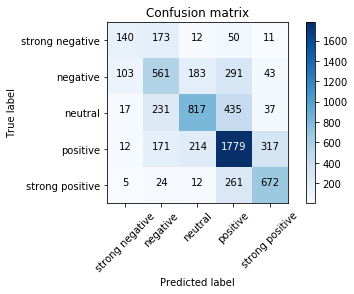

In [160]:
predict3 = model6.predict(X_test, verbose=0)
confusion_mtx = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(predict3,axis=1)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = classes) 

#### use bigram set conv1d kernel_size = 2

In [162]:
model7 = Sequential()
model7.add(Embedding(len(tokenizer.word_index)+1, 200, weights=[embedding_matrix], input_length=65, trainable=False))
model7.add(Dropout(0.2))
model7.add(Conv1D(250, 2, padding='valid', activation='relu'))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
model7.add(MaxPooling1D(3))
model7.add(Flatten())
model7.add(Dense(100, activation='relu'))
model7.add(Dense(5, activation='softmax'))

In [163]:
model7.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result7 = model6.fit(partial_x_train, partial_y_train, epochs=10,shuffle=True,
                   batch_size = 512, validation_data=(x_val,y_val),callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/10
53219/53219 [==============================] - 2s 43us/step - loss: 0.2468 - acc: 0.8928 - val_loss: 0.3192 - val_acc: 0.8574
Epoch 2/10
53219/53219 [==============================] - 2s 33us/step - loss: 0.2344 - acc: 0.8988 - val_loss: 0.3333 - val_acc: 0.8497
Epoch 3/10
53219/53219 [==============================] - 2s 33us/step - loss: 0.2226 - acc: 0.9052 - val_loss: 0.3295 - val_acc: 0.8523


In [164]:
model7.evaluate(X_test, y_test, verbose=0)[1]

0.800000011920929

#### add LSTM layer


In [165]:
from keras.layers import LSTM

In [169]:
model8 = Sequential()
model8.add(Embedding(len(tokenizer.word_index)+1, 200, weights=[embedding_matrix], input_length=65, trainable=False))
model8.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model8.add(Dropout(0.2))

model8.add(Dense(5, activation='softmax'))
model8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 65, 200)           5864200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_43 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 5)                 1005      
Total params: 6,186,005
Trainable params: 321,805
Non-trainable params: 5,864,200
_________________________________________________________________


In [170]:
model8.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result8 = model6.fit(partial_x_train, partial_y_train, epochs=10,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 53219 samples, validate on 5914 samples
Epoch 1/10
53219/53219 [==============================] - 2s 44us/step - loss: 0.1792 - acc: 0.9262 - val_loss: 0.3661 - val_acc: 0.8520
Epoch 2/10
53219/53219 [==============================] - 2s 33us/step - loss: 0.1731 - acc: 0.9286 - val_loss: 0.3674 - val_acc: 0.8492
Epoch 3/10
53219/53219 [==============================] - 2s 34us/step - loss: 0.1637 - acc: 0.9338 - val_loss: 0.3809 - val_acc: 0.8488
Epoch 4/10
53219/53219 [==============================] - 2s 33us/step - loss: 0.1556 - acc: 0.9373 - val_loss: 0.3975 - val_acc: 0.8389
Epoch 5/10
53219/53219 [==============================] - 2s 33us/step - loss: 0.1491 - acc: 0.9400 - val_loss: 0.4091 - val_acc: 0.8482
Epoch 6/10
53219/53219 [==============================] - 2s 34us/step - loss: 0.1420 - acc: 0.9436 - val_loss: 0.4308 - val_acc: 0.8485
Epoch 7/10
53219/53219 [==============================] - 2s 33us/step - loss: 0.1356 - acc: 0.9464 - val_loss: 0.4191 - val_acc:

In [171]:
model8.evaluate(X_test, y_test, verbose=0)[1]

0.800000011920929

#### use doc2vec model

In [174]:
doc_model = gensim.models.Doc2Vec.load('doc2vec.w2v')


In [175]:
len(doc_model.docvecs)

65704

In [176]:
x_model5 = []
for i in range(len(doc_model.docvecs)):
    x_model5.append(doc_model.docvecs[i])

In [177]:
np.array(x_model5)

array([[ 0.15150775,  0.07151749,  0.07180201, ...,  0.132304  ,
         0.0329794 , -0.08733618],
       [ 0.0686096 , -0.01888565,  0.08451887, ..., -0.05630482,
        -0.08765972, -0.23774159],
       [-0.00334271, -0.00906468, -0.02458597, ...,  0.00251458,
        -0.02325469, -0.02219841],
       ...,
       [ 0.1284593 , -0.1165425 , -0.13060783, ..., -0.03808872,
        -0.05020564,  0.05547182],
       [-0.02539518,  0.01650828,  0.01879966, ...,  0.0625739 ,
         0.02941871, -0.15449521],
       [ 0.0593664 , -0.02316635, -0.04938976, ...,  0.02264089,
        -0.01537439, -0.03399729]], dtype=float32)

In [178]:
X_train, X_test, y_train, y_test = train_test_split(np.array(x_model5), y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [179]:
#build first nerual network
model5 = Sequential()

model5.add(Dense(32, activation = 'relu', input_shape = (200,)))

model5.add(Dropout(0.2))

model5.add(Dense(5, activation='sigmoid'))
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_44 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 5)                 165       
Total params: 6,597
Trainable params: 6,597
Non-trainable params: 0
_________________________________________________________________


In [180]:
model5.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
               
         metrics=['acc'])

In [182]:
result5 = model5.fit(partial_x_train, partial_y_train, epochs=20,shuffle=True,
                   batch_size = 15, validation_data=(x_val,y_val),callbacks=callbacks)

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 9s 168us/step - loss: 0.4280 - acc: 0.8095 - val_loss: 0.4199 - val_acc: 0.8133
Epoch 2/20
53219/53219 [==============================] - 9s 169us/step - loss: 0.4269 - acc: 0.8109 - val_loss: 0.4179 - val_acc: 0.8176
Epoch 3/20
53219/53219 [==============================] - 9s 169us/step - loss: 0.4240 - acc: 0.8128 - val_loss: 0.4159 - val_acc: 0.8171
Epoch 4/20
53219/53219 [==============================] - 9s 170us/step - loss: 0.4225 - acc: 0.8131 - val_loss: 0.4145 - val_acc: 0.8184
Epoch 5/20
53219/53219 [==============================] - 9s 170us/step - loss: 0.4212 - acc: 0.8138 - val_loss: 0.4138 - val_acc: 0.8172
Epoch 6/20
53219/53219 [==============================] - 9s 170us/step - loss: 0.4208 - acc: 0.8142 - val_loss: 0.4141 - val_acc: 0.8185
Epoch 7/20
53219/53219 [==============================] - 9s 171us/step - loss: 0.4205 - acc: 0.8137 - val_loss: 0.4147 - v

In [183]:
model5.evaluate(X_test, y_test, verbose=0)[1]

0.8175924674340932

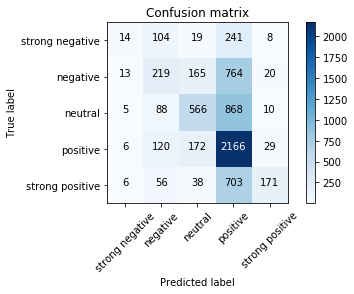

In [184]:
predict4 = model5.predict(X_test, verbose=0)
confusion_mtx = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(predict4,axis=1)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = classes) 

#### compare with other machine learing algorithm

In [143]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svc = SVC()
lr = LogisticRegression()
clf = MultinomialNB(alpha = 0.01) 
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
X =  tf_vec 
y_mach= data.label_value

In [144]:
models = [# use tf_idf as input
    ("lr", lr),
    ("svc", svc),
    ("rf", rf),
    ("clf", clf),
    ("ada", ada)

]


unsorted_scores = [(name, cross_val_score(model, X, y_mach, cv=5).mean()) for name, model in models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print(scores)

[('lr', 0.57322458961829026), ('rf', 0.51079419965764472), ('clf', 0.47959253998347667), ('ada', 0.46123799223410333), ('svc', 0.38416230503245924)]


In [153]:
pd.DataFrame(dict(scores),index=[0])

,ada,clf,lr,rf,svc
0,0.461238,0.479593,0.573225,0.510794,0.384162


In [154]:

%%time
models = [# use doc2vec as input
    ("lr", lr),
    ("svc", svc),
    ("rf", rf),
    
    ("ada", ada)

]


unsorted_scores = [(name, cross_val_score(model, np.array(x_model5), y_mach, cv=5).mean()) for name, model in models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print(scores)

[('ada', 0.42650407400968549), ('lr', 0.39824053777778212), ('svc', 0.38416230503245924), ('rf', 0.38244368166579801)]
Wall time: 1h 40min 47s


In [155]:
pd.DataFrame(dict(scores),index=[0])

,ada,lr,rf,svc
0,0.426504,0.398241,0.382444,0.384162


#### summary:
deep learing model have high performance in this model
the parameter tuning in deep learing model is very important, because there are no grid search in keras and for avoiding repeating code, I just keep the parameter that show the best result.
add word2vec not increase the performance of this model much, but the model with word2vec and doc2vec have low overfitting problem